**CASE STUDY: <br> AUTOMATION OF STANDBY DUTY PLANNING FOR RESCUE DRIVERS VIA A
FORECASTING MODEL <br> EVALUATION**

Import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from datetime import datetime, time, timedelta, date

Import csv file to a dataframe abbreviated as df.

In [2]:
# Define function to read csv file into dataset
def read_csv_file(file): 
    dataset = pd.read_csv(file,header=0)
    return dataset
    
df = read_csv_file(r"C:\Users\nayma\anaconda3\Scripts\case_study\transformed_data.csv")
# Format the date
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d', errors = 'coerce')

In [3]:
df.head()

,days,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,date_train
0,1,2016-04-01,73,8154,1700,90,4,0,736055
1,2,2016-04-02,64,8526,1700,90,70,0,736056
2,3,2016-04-03,68,8088,1700,90,0,0,736057
3,4,2016-04-04,71,7044,1700,90,0,0,736058
4,5,2016-04-05,63,7236,1700,90,0,0,736059


In [4]:
dict_mb = {2016: {'min': 8136, 'm': 0.1931732979337978, 'b': -1579.6676846267887},
 2017: {'min': 8514, 'm': 0.19142644367145642, 'b': -1655.5810228548087},
 2018: {'min': 9060, 'm': 0.19696741820956948, 'b': -1791.9393396528164},
 2019: {'min': 9648, 'm': 0.20123246681605905, 'b': -1938.5467501168534}}

colors = {'blue': "#0072BD" , 'orange': "#D95319", 'green': "#77AC30", 'yellow': "#EDB120", 'red': "#A2142F", 'lightb': "#4DBEEE", 'purple': "#7E2F8E"}

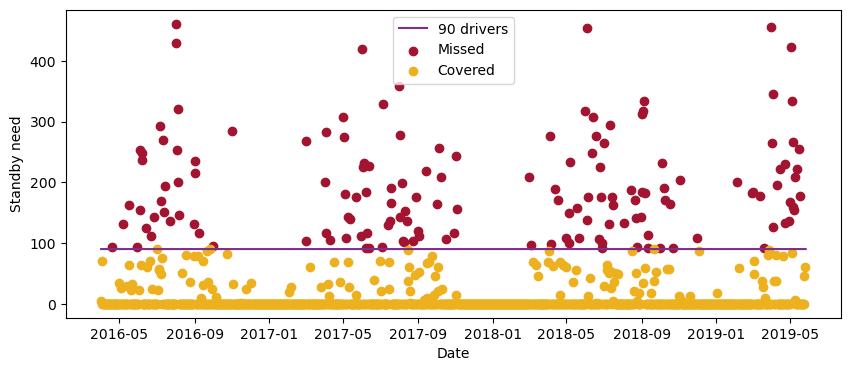

In [5]:
cov_x = []
cov_y = []
miss_x = []
miss_y = []

for i in range(len(df.sby_need)-1):
    row = df.iloc[i]
    if 90 >= df.sby_need[i]:
        cov_x.append(row.date)
        cov_y.append(row.sby_need)
    else:
        miss_x.append(row.date)
        miss_y.append(row.sby_need)


plt.figure(figsize=(10, 4))
plt.ylabel('Standby need')
plt.xlabel('Date')
plt.plot(df.date, np.full(1152, 90), color=colors['purple'])
plt.scatter(miss_x, miss_y, color=colors['red'])
plt.scatter(cov_x, cov_y, color=colors['yellow'])


plt.legend(['90 drivers', 'Missed' ,'Covered'])

**Model**

In [6]:
def prediction_model(model):
    years_list = df.date.dt.year.unique().tolist()
    dynamic_need = []
    for i in years_list:
        X = df[df.date.dt.year == i].date_train
        y_pred = model(X)
        dynamic_year = []
        for j in y_pred:
            if j < dict_mb[i]['min']:
                dynamic_year += [0]     
            else:
                z = ceil(dict_mb[i]['m'] * j + dict_mb[i]['b'])
                if z < 0:
                    z = 0
                dynamic_year += [z]
        dynamic_need += dynamic_year
    return dynamic_need

In [7]:
def error_of_prediction(calendar_n_sby):
    coverage = np.array(calendar_n_sby) - df.sby_need
    error = sum(1 for i in coverage if i < 0)
    error_percent = round((len(calendar_n_sby) - error)/len(calendar_n_sby), 2)
    return error_percent

In [8]:
def inactivated(dynamic_need):
    inactivated = dynamic_need - df.sby_need
    inactivated[inactivated < 0] = 0
    return np.array(inactivated).sum()

In [9]:
def sine_fun_D(X):
    a = 8030
    b = 2.08
    c = 980
    d = 0.0175   #frequency
    e = 50      #start period
    fun = a + b*(X-736055) + c*np.sin(d*X+e)
    return fun

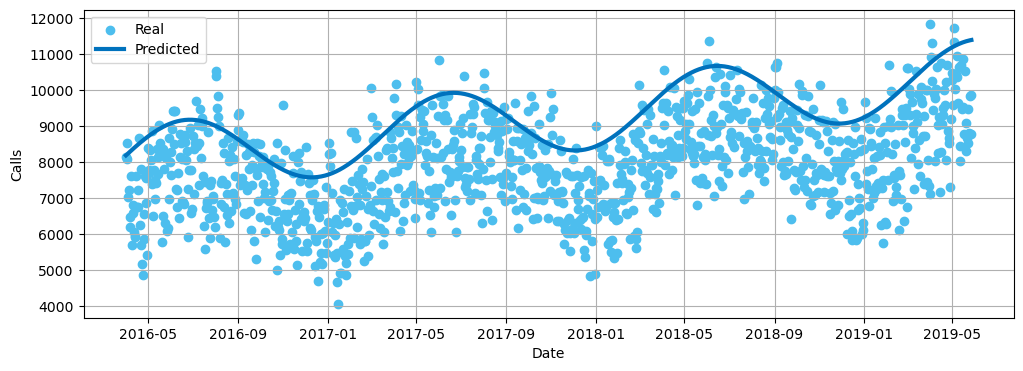

In [10]:
plt.figure(figsize=(12, 4))
plt.scatter(df.date, df.calls, color=colors['lightb'])
plt.plot(df.date, sine_fun_D(df.date_train), color=colors['blue'], linewidth=3)
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend(['Real', 'Predicted'])
plt.grid()
plt.show()

In [11]:
dynamic_need = prediction_model(sine_fun_D)
error = error_of_prediction(dynamic_need)

print("The percentage of dates in which there are enough standby drivers is ",error, ".")

print("With the new dynamic system a total of ", inactivated(dynamic_need), " standby drivers allocated throughout the years, of which ", 
      round(inactivated(dynamic_need)/np.array(dynamic_need).sum(), 2) , " is the percentage of inactive.")

The percentage of dates in which there are enough standby drivers is  0.92 .
With the new dynamic system a total of  102489  standby drivers allocated throughout the years, of which  0.79  is the percentage of inactive.


**Evaluation**

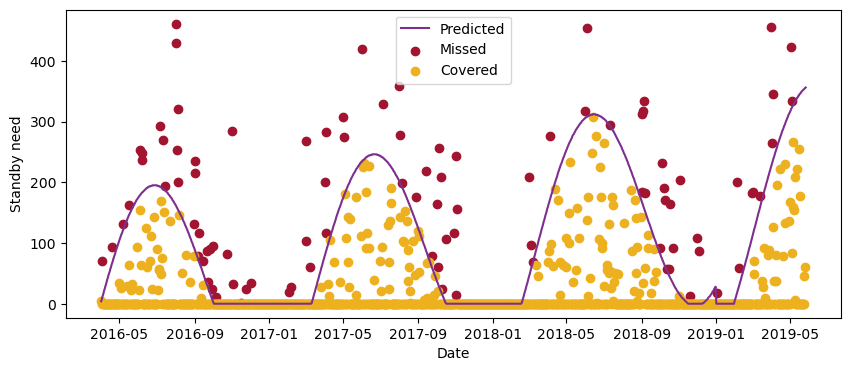

In [12]:
cov_x = []
cov_y = []
miss_x = []
miss_y = []

for i in range(len(dynamic_need)-1):
    row = df.iloc[i]
    if dynamic_need[i] >= df.sby_need[i]:
        cov_x.append(row.date)
        cov_y.append(row.sby_need)
    else:
        miss_x.append(row.date)
        miss_y.append(row.sby_need)


plt.figure(figsize=(10, 4))
plt.ylabel('Standby need')
plt.xlabel('Date')
plt.plot(df.date, dynamic_need, color=colors['purple'])
plt.scatter(miss_x, miss_y, color=colors['red'])
plt.scatter(cov_x, cov_y, color=colors['yellow'])


plt.legend(['Predicted', 'Missed' ,'Covered'])

In [13]:
df_miss = pd.DataFrame({'date': miss_x, 'standby_need': miss_y})

In [14]:
df_miss['date'] = pd.to_datetime(df_miss['date'], format = '%Y-%m-%d', errors = 'coerce')

In [15]:
df_miss.date.dt.year.value_counts(normalize= True, sort = False)
df_miss.date.dt.year.value_counts(sort = False)

date
2016    33
2017    28
2018    24
2019    11
Name: count, dtype: int64

In [16]:
df_miss.date.dt.month.value_counts(sort = False, normalize= True)

date
4     0.093750
5     0.062500
6     0.062500
7     0.052083
8     0.104167
9     0.177083
10    0.177083
11    0.093750
12    0.031250
2     0.041667
3     0.093750
1     0.010417
Name: proportion, dtype: float64

In [17]:
for i in [2016, 2017, 2018, 2019]:
    print (i, df_miss[df_miss.date.dt.year == i].date.dt.month.value_counts(sort = False))

2016 date
4      2
5      2
6      3
7      3
8      6
9     10
10     2
11     4
12     1
Name: count, dtype: int64
2017 date
2     2
3     3
4     3
5     2
6     1
7     1
8     4
9     2
10    7
11    3
Name: count, dtype: int64
2018 date
3     3
4     1
6     2
7     1
9     5
10    8
11    2
12    2
Name: count, dtype: int64
2019 date
1    1
2    2
3    3
4    3
5    2
Name: count, dtype: int64


In [18]:
df_miss.standby_need.min()

2

In [19]:
df_miss.standby_need.describe()

count     96.000000
mean     182.114583
std      118.447578
min        2.000000
25%       85.000000
50%      182.000000
75%      268.250000
max      461.000000
Name: standby_need, dtype: float64

In [20]:
from sklearn.metrics import mean_absolute_error
np.sqrt(mean_absolute_error(df.sby_need, dynamic_need))

9.806726008204777

In [21]:
np.sqrt(mean_absolute_error(df.sby_need, df.n_sby))

9.300444284489258

In [22]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(df.sby_need, dynamic_need)

3.1777742995697754e+17

In [23]:
mean_absolute_percentage_error(df.sby_need, df.n_sby)

3.061040371728384e+17

In [24]:
i = 2016
j = 4
while [i, j] != [2019, 6]:
    work = df[df.date.dt.year == i][['date', 'sby_need']]
    print(i, j, ": 90 is", np.percentile(work[work.date.dt.month == j].sby_need, 90).round(),", 95 is", np.percentile(work[work.date.dt.month == j].sby_need, 95).round(), ": min sby missed", df_miss[(df_miss.date.dt.month == j) & (df_miss.date.dt.year == i)].standby_need.min())
    j += 1
    if j == 13:
        j = 1
        i += 1

2016 4 : 90 is 0.0 , 95 is 40.0 : min sby missed 70
2016 5 : 90 is 63.0 , 95 is 112.0 : min sby missed 131
2016 6 : 90 is 162.0 , 95 is 243.0 : min sby missed 236
2016 7 : 90 is 169.0 , 95 is 232.0 : min sby missed 194
2016 8 : 90 is 253.0 , 95 is 375.0 : min sby missed 132
2016 9 : 90 is 97.0 , 95 is 171.0 : min sby missed 24
2016 10 : 90 is 0.0 , 95 is 6.0 : min sby missed 11
2016 11 : 90 is 4.0 , 95 is 29.0 : min sby missed 2
2016 12 : 90 is 0.0 , 95 is 0.0 : min sby missed 34
2017 1 : 90 is 0.0 , 95 is 0.0 : min sby missed nan
2017 2 : 90 is 0.0 , 95 is 12.0 : min sby missed 19
2017 3 : 90 is 28.0 , 95 is 82.0 : min sby missed 61
2017 4 : 90 is 106.0 , 95 is 163.0 : min sby missed 117
2017 5 : 90 is 176.0 , 95 is 228.0 : min sby missed 275
2017 6 : 90 is 225.0 , 95 is 230.0 : min sby missed 420
2017 7 : 90 is 137.0 , 95 is 178.0 : min sby missed 329
2017 8 : 90 is 176.0 , 95 is 238.0 : min sby missed 176
2017 9 : 90 is 81.0 , 95 is 116.0 : min sby missed 78
2017 10 : 90 is 116.0 , 

In [25]:
def min_outlier_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers.min()

In [38]:
out_outliars =  0
outliars = pd.DataFrame()
miss = pd.DataFrame()
i = 2016
j = 4
while [i, j] != [2019, 6]:
    df_subset = df[(df.date.dt.year == i) & (df.date.dt.month == j)].sby_need
    number = df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j)].standby_need.min()
    outlier = min_outlier_IQR(df_subset)
    if outlier > number:
        print(i, j, "is a true failure! min outlier", outlier,  ", ", len(df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j)].standby_need), ", nums are")
        outliars = pd.concat([outliars, df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j)& (df_miss.standby_need>=number)&(df_miss.standby_need<=outlier)]], axis=0)
        print(df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j)& (df_miss.standby_need>=number)&(df_miss.standby_need<=outlier)])
        out_outliars += len(df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j)].standby_need)
        miss = pd.concat([miss, df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j) & (df_miss.standby_need>=number) & (df_miss.standby_need > outlier)]], axis=0)
    else:
        miss  = pd.concat([miss, df_miss[(df_miss.date.dt.year == i) & (df_miss.date.dt.month == j)]], axis=0)
    j += 1
    if j == 13:
        j = 1
        i += 1

print("Of the dates that additional drivers are needed, in ", round(out_outliars/len(df_miss),2), "the number of standby drivers were outliars in the yearly average.")

2016 8 is a true failure! min outlier 201 ,  6 , nums are
         date  standby_need
14 2016-08-05           201
15 2016-08-31           132
2016 9 is a true failure! min outlier 216 ,  10 , nums are
         date  standby_need
16 2016-09-01           216
18 2016-09-07            78
19 2016-09-08           117
20 2016-09-14            71
21 2016-09-21            87
22 2016-09-22            35
23 2016-09-26            90
24 2016-09-29            24
25 2016-09-30            95
2017 8 is a true failure! min outlier 277 ,  4 , nums are
         date  standby_need
46 2017-08-02           277
47 2017-08-05           199
48 2017-08-29           176
2017 9 is a true failure! min outlier 112 ,  2 , nums are
         date  standby_need
50 2017-09-23            78
2017 10 is a true failure! min outlier 60 ,  7 , nums are
         date  standby_need
52 2017-10-04            60
55 2017-10-10            25
2018 6 is a true failure! min outlier 454 ,  2 , nums are
         date  standby_need
65 2018

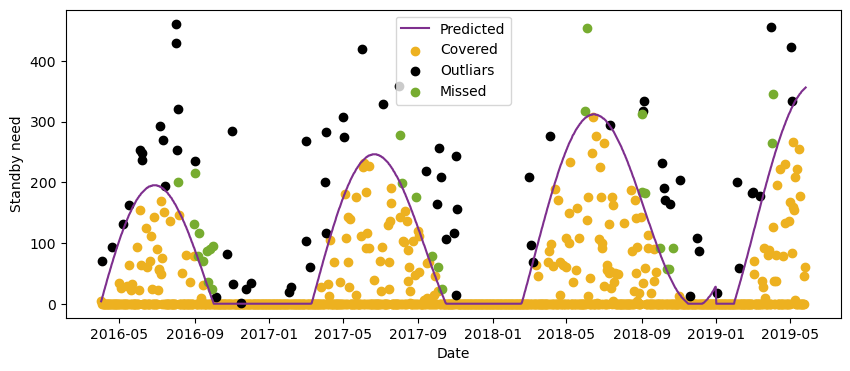

In [39]:
plt.figure(figsize=(10, 4))
plt.ylabel('Standby need')
plt.xlabel('Date')
plt.plot(df.date, dynamic_need, color=colors['purple'])
plt.scatter(cov_x, cov_y, color=colors['yellow'])
plt.scatter(miss.date, miss.standby_need, color='black')

plt.scatter(outliars.date, outliars.standby_need, color=colors['green'])


plt.legend(['Predicted', 'Covered', 'Outliars','Missed' ])

In [40]:
len(miss)

68

In [32]:
len(outliars)

28

In [50]:
print(round(len(miss)/(len(outliars)+ len(miss)),2), "percentage are outliars.")

0.71 percentage are outliars.


In [47]:
outliars.date.dt.month.value_counts(normalize=True)

date
9     0.464286
10    0.214286
8     0.178571
6     0.071429
4     0.071429
Name: proportion, dtype: float64